# EngSAF Dataset EDA Analysis


## Overview of Analyses:
1. Overall Score Distribution (train.csv)
2. Item-Level Distribution (train.csv)
3. Response Length vs. Score (train.csv)
4. Partial Credit Analysis (train.csv)
5. Outlier Detection (train.csv, val.csv)
6. Data Balance Across Questions (train.csv, val.csv)
7. Unseen Data Preview (unseen_question.csv & unseen_answers.csv)

## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# Set visualization style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

# For reproducibility
np.random.seed(42)

In [2]:
# Load the datasets
data_path = './EngSAFDataset/'
train_df = pd.read_csv(data_path + 'train.csv')
val_df = pd.read_csv(data_path + 'val.csv')
unseen_answers_df = pd.read_csv(data_path + 'unseen_answers.csv')
unseen_question_df = pd.read_csv(data_path + 'unseen_question.csv')

# Print dataset shapes
print(f"Train data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Unseen answers data shape: {unseen_answers_df.shape}")
print(f"Unseen questions data shape: {unseen_question_df.shape}")

Train data shape: (3662, 6)
Validation data shape: (407, 6)
Unseen answers data shape: (980, 6)
Unseen questions data shape: (765, 6)


In [3]:
train_df.head()

,Question_id,Question,Student Answer,Correct Answer,output_label,feedback
0,NaN,Q1. State TRUE or FALSE and justify. No correc...,FALSE,"False, parent and child processes are two inde...",0,Your answer is incorrect. Parent and child pro...
1,324731.0,A rating curve is only valid when?,Rating curve is valid only when there is no re...,A rating curve is only valid when there is no ...,1,Your answer is partially correct. While the ...
2,42540.0,c. Assume the OS is using a lazy allocation po...,True\nThe PC in the user mode of the process ...,FALSE\nFixing the mapping is only part of oper...,0,The student response is incorrect. The OS page...
3,301390.0,To segment the rose petals [4 marks]:,Red color has hue around 0 degrees. So a narr...,To segment rose petals\nH (Hue) -- Narrow rang...,2,Impressive! You have a clear understanding of ...
4,275834.0,Write three parameters which affect ...,"Frequency of vibration, Amplitude of vibration...","Frequency of vibration, Amplitude of vibration...",2,"Yes, you got it right! Remember, MRR can als..."


In [4]:
print("Train data columns:", train_df.columns.tolist())
print("\nValidation data columns:", val_df.columns.tolist())
print("\nUnseen answers data columns:", unseen_answers_df.columns.tolist())
print("\nUnseen questions data columns:", unseen_question_df.columns.tolist())

Train data columns: ['Question_id', 'Question', 'Student Answer', 'Correct Answer', 'output_label', 'feedback']

Validation data columns: ['Question_id', 'Question', 'Student Answer', 'Correct Answer', 'output_label', 'feedback']

Unseen answers data columns: ['Question_id', 'Question', 'Student Answer', 'Correct Answer', 'output_label', 'feedback']

Unseen questions data columns: ['Question_id', 'Question', 'Student Answer', 'Correct Answer', 'output_label', 'feedback']


In [5]:
print("Missing values in train data:")
print(train_df.isnull().sum())

print("\nMissing values in validation data:")
print(val_df.isnull().sum())

print("\nMissing values in unseen answers data:")
print(unseen_answers_df.isnull().sum())

print("\nMissing values in unseen questions data:")
print(unseen_question_df.isnull().sum())

Missing values in train data:
Question_id       709
Question            0
Student Answer     12
Correct Answer      0
output_label        0
feedback            0
dtype: int64

Missing values in validation data:
Question_id       91
Question           0
Student Answer     2
Correct Answer     0
output_label       0
feedback           0
dtype: int64

Missing values in unseen answers data:
Question_id       180
Question            0
Student Answer      2
Correct Answer      0
output_label        0
feedback            0
dtype: int64

Missing values in unseen questions data:
Question_id       0
Question          0
Student Answer    0
Correct Answer    0
output_label      0
feedback          0
dtype: int64


## 2. Overall Score Distribution (train.csv)

In [6]:
# Function to perform basic text cleaning without changing content
def basic_clean(text):
    if isinstance(text, str):
        # Normalize spaces
        text = re.sub('\s+', ' ', text)
        text = text.strip()
        return text
    return text

In [7]:
# Identify the column containing scores
score_column = None
for col in train_df.columns:
    if col.lower() in ['score', 'grade', 'mark', 'label']:
        score_column = col
        break

if not score_column:
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        # Take the first numeric column that has values 0, 1, 2
        for col in numeric_cols:
            unique_vals = set(train_df[col].unique())
            if unique_vals.issubset({0, 1, 2}):
                score_column = col
                break

print(f"Using '{score_column}' as the score column.")

Using 'output_label' as the score column.


In [8]:
# Compute overall score distribution in training data
score_counts = train_df[score_column].value_counts().sort_index()
score_percentages = train_df[score_column].value_counts(normalize=True).sort_index() * 100

# Create a dataframe for the distribution
distribution_df = pd.DataFrame({
    'Count': score_counts,
    'Percentage': score_percentages
})
distribution_df.index = ['Incorrect (0)', 'Partially Correct (1)', 'Correct (2)']

print("Overall Score Distribution in Training Data:")
display(distribution_df)

Overall Score Distribution in Training Data:


,Count,Percentage
Incorrect (0),846,23.102130
Partially Correct (1),1268,34.625887
Correct (2),1548,42.271983


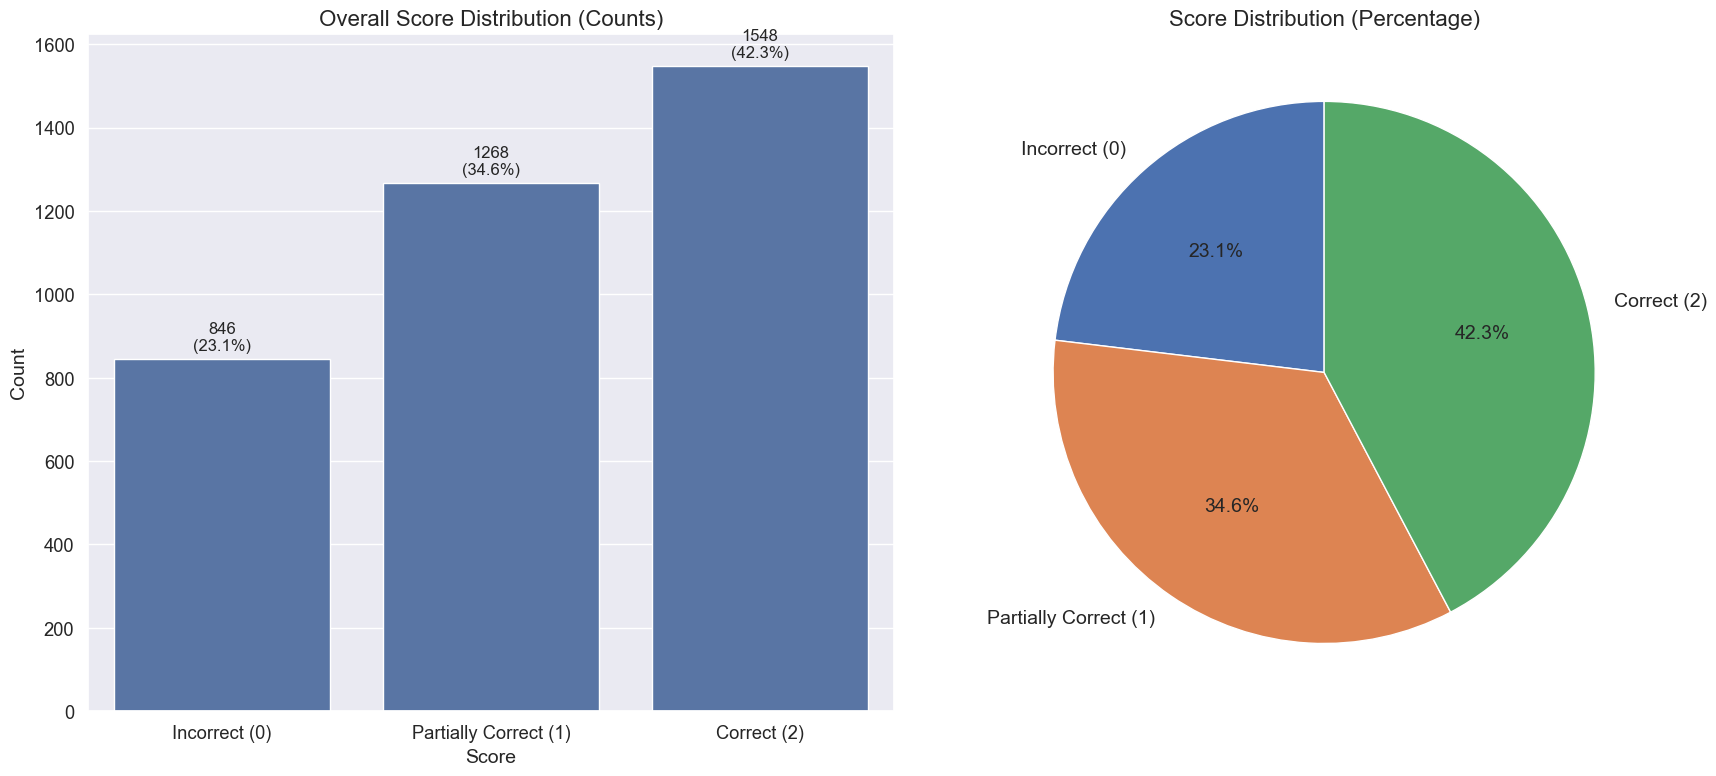

In [9]:
# Visualize the overall score distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Bar chart
sns.barplot(x=distribution_df.index, y='Count', data=distribution_df, ax=ax1)
ax1.set_title('Overall Score Distribution (Counts)', fontsize=16)
ax1.set_xlabel('Score', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)

for i, count in enumerate(distribution_df['Count']):
    ax1.text(i, count + 20, f"{count}\n({distribution_df['Percentage'][i]:.1f}%)", 
             ha='center', fontsize=12)

# Pie chart
ax2.pie(distribution_df['Count'], labels=distribution_df.index, autopct='%1.1f%%', 
        startangle=90, textprops={'fontsize': 14})
ax2.set_title('Score Distribution (Percentage)', fontsize=16)

plt.tight_layout()
plt.show()

## 3. Item-Level Distribution (train.csv)

In [10]:
# Identify the column containing questions
question_col = None
for col in train_df.columns:
    if 'question' in col.lower():
        question_col = col
        break

if not question_col:
    for col in train_df.columns:
        if col.lower() in ['item', 'prompt', 'stem', 'task']:
            question_col = col
            break

print(f"Using '{question_col}' as the question column.")

Using 'Question_id' as the question column.


In [11]:
# Group by question and calculate score distributions
question_scores = train_df.groupby(question_col)[score_column].value_counts().unstack().fillna(0)

# Calculate percentages for each question
question_scores_pct = question_scores.div(question_scores.sum(axis=1), axis=0) * 100

# Number of responses per question
question_counts = train_df[question_col].value_counts().sort_values(ascending=False)

# Display the number of unique questions
print(f"Number of unique questions in the training data: {len(question_scores)}")

# Display distributions for the top 10 most frequent questions
top_questions = question_counts.head(10).index
print("\nScore distribution (counts) for the top 10 most frequent questions:")
display(question_scores.loc[top_questions].rename(columns={0: 'Incorrect', 1: 'Partially Correct', 2: 'Correct'}))

print("\nScore distribution (percentages) for the top 10 most frequent questions:")
display(question_scores_pct.loc[top_questions].rename(columns={0: 'Incorrect %', 1: 'Partially Correct %', 2: 'Correct %'}).round(1))

Number of unique questions in the training data: 97

Score distribution (counts) for the top 10 most frequent questions:


output_label,Incorrect,Partially Correct,Correct
Question_id,,,
219127.0,50.0,189.0,75.0
301390.0,22.0,89.0,61.0
42541.0,22.0,6.0,114.0
301392.0,13.0,87.0,40.0
42540.0,59.0,0.0,77.0
42544.0,34.0,69.0,17.0
42546.0,40.0,72.0,8.0
324829.0,9.0,17.0,22.0
198669.0,5.0,22.0,20.0



Score distribution (percentages) for the top 10 most frequent questions:


output_label,Incorrect %,Partially Correct %,Correct %
Question_id,,,
219127.0,15.9,60.2,23.9
301390.0,12.8,51.7,35.5
42541.0,15.5,4.2,80.3
301392.0,9.3,62.1,28.6
42540.0,43.4,0.0,56.6
42544.0,28.3,57.5,14.2
42546.0,33.3,60.0,6.7
324829.0,18.8,35.4,45.8
198669.0,10.6,46.8,42.6


In [12]:
# Identify "easy" and "difficult" questions based on score distributions

min_responses = 10
filtered_questions = question_counts[question_counts >= min_responses].index
filtered_scores = question_scores_pct.loc[filtered_questions]

# Classify questions based on percentage of correct answers
easy_questions = filtered_scores[filtered_scores[2] >= 70].index
hard_questions = filtered_scores[filtered_scores[0] >= 50].index

print(f"Number of 'easy' questions (≥70% correct answers): {len(easy_questions)}")
print(f"Number of 'difficult' questions (≥50% incorrect answers): {len(hard_questions)}")

# Display score distributions for the top 5 easiest questions
if len(easy_questions) > 0:
    top_easy = filtered_scores.loc[easy_questions].sort_values(by=2, ascending=False).head(5)
    print("\nScore distribution for the 5 easiest questions:")
    display(top_easy.rename(columns={0: 'Incorrect %', 1: 'Partially Correct %', 2: 'Correct %'}).round(1))
else:
    print("\nNo easy questions found based on the criteria.")

# Display score distributions for the top 5 most difficult questions
if len(hard_questions) > 0:
    top_hard = filtered_scores.loc[hard_questions].sort_values(by=0, ascending=False).head(5)
    print("\nScore distribution for the 5 most difficult questions:")
    display(top_hard.rename(columns={0: 'Incorrect %', 1: 'Partially Correct %', 2: 'Correct %'}).round(1))
else:
    print("\nNo difficult questions found based on the criteria.")

Number of 'easy' questions (≥70% correct answers): 5
Number of 'difficult' questions (≥50% incorrect answers): 6

Score distribution for the 5 easiest questions:


output_label,Incorrect %,Partially Correct %,Correct %
Question_id,,,
284401.0,10.0,0.0,90.0
260792.0,10.0,5.0,85.0
42541.0,15.5,4.2,80.3
260816.0,21.4,0.0,78.6
346460.0,0.0,27.3,72.7



Score distribution for the 5 most difficult questions:


output_label,Incorrect %,Partially Correct %,Correct %
Question_id,,,
30144.0,64.7,5.9,29.4
290959.0,60.0,10.0,30.0
324827.0,54.5,18.2,27.3
137714.0,52.4,23.8,23.8
76516.0,50.0,4.5,45.5


<Figure size 1500x1000 with 0 Axes>

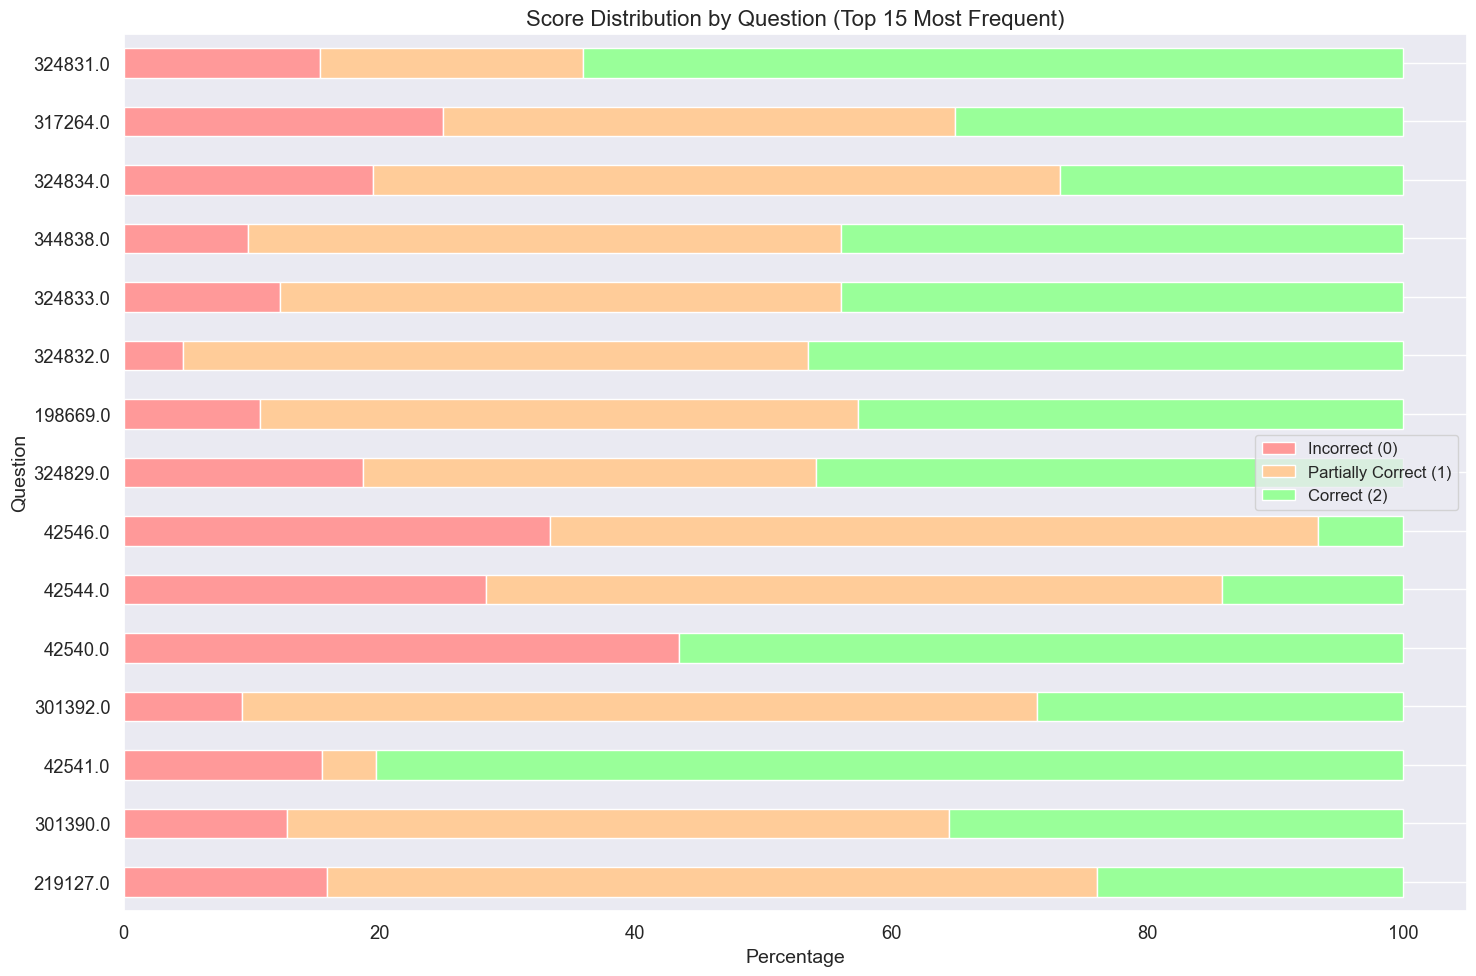

In [13]:
# Visualize item-level distribution for top 15 most frequent questions

top15_questions = question_counts.head(15).index
plot_data = question_scores_pct.loc[top15_questions]
def truncate_text(text, max_len=50):
    if isinstance(text, str) and len(text) > max_len:
        return text[:max_len] + '...'
    return text

plot_data.index = [truncate_text(q) for q in plot_data.index]

# Create stacked bar chart
plt.figure(figsize=(15, 10))
plot_data.plot(kind='barh', stacked=True, figsize=(15, 10), 
               color=['#ff9999', '#ffcc99', '#99ff99'])
plt.title('Score Distribution by Question (Top 15 Most Frequent)', fontsize=16)
plt.xlabel('Percentage', fontsize=14)
plt.ylabel('Question', fontsize=14)
plt.legend(['Incorrect (0)', 'Partially Correct (1)', 'Correct (2)'], fontsize=12)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

## 4. Response Length vs. Score (train.csv)

In [14]:
# Identify the column containing answers
answer_col = None
for col in train_df.columns:
    if col.lower() in ['answer', 'response', 'student_answer', 'student_response']:
        answer_col = col
        break

if not answer_col:
    # Try to find any column with 'answer' in the name
    for col in train_df.columns:
        if 'answer' in col.lower():
            answer_col = col
            break

print(f"Using '{answer_col}' as the answer column.")

Using 'Student Answer' as the answer column.


In [15]:
# Function to count words in a text
def count_words(text):
    if not isinstance(text, str):
        return 0
    # Remove punctuation and split by whitespace
    words = re.sub(r'[^\w\s]', '', text).split()
    return len(words)

# Calculate word counts for each response
train_df['word_count'] = train_df[answer_col].apply(count_words)

# Group by score and calculate word count statistics
word_count_stats = train_df.groupby(score_column)['word_count'].agg(['count', 'mean', 'std', 'min', 'max', 'median'])
word_count_stats = word_count_stats.rename(index={0: 'Incorrect (0)', 1: 'Partially Correct (1)', 2: 'Correct (2)'})

# Display word count statistics by score
print("Word Count Statistics by Score:")
display(word_count_stats.round(1))

Word Count Statistics by Score:


,count,mean,std,min,max,median
output_label,,,,,,
Incorrect (0),846,18.8,22.5,0,286,12.5
Partially Correct (1),1268,32.0,32.5,2,234,21.0
Correct (2),1548,26.0,21.6,1,173,21.5


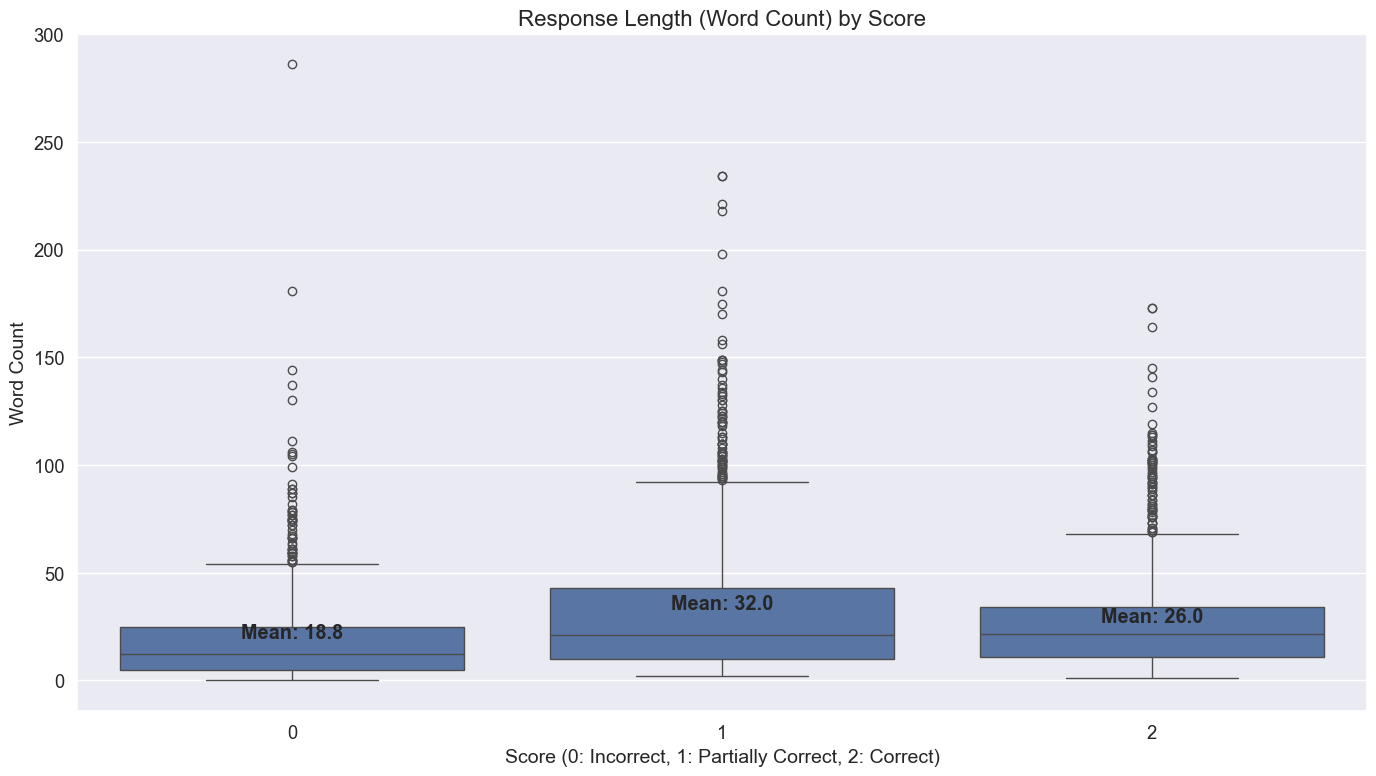

In [16]:
# Visualize the relationship between response length and score
plt.figure(figsize=(14, 8))

# Box plot
sns.boxplot(x=score_column, y='word_count', data=train_df)
plt.title('Response Length (Word Count) by Score', fontsize=16)
plt.xlabel('Score (0: Incorrect, 1: Partially Correct, 2: Correct)', fontsize=14)
plt.ylabel('Word Count', fontsize=14)

# Add mean word count labels
for i, score in enumerate([0, 1, 2]):
    mean_wc = train_df[train_df[score_column] == score]['word_count'].mean()
    plt.text(i, mean_wc + 1, f"Mean: {mean_wc:.1f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

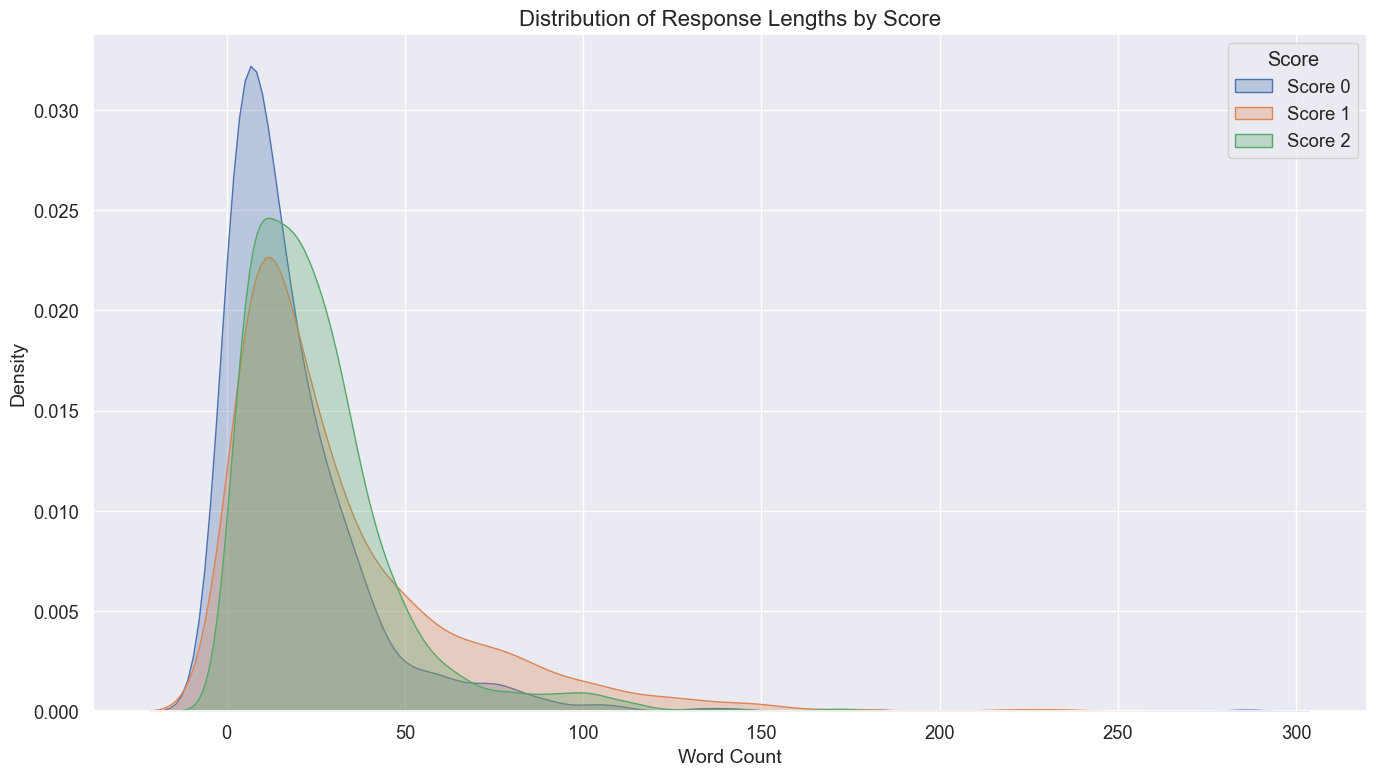

In [17]:
# Calculate and visualize the distribution of word counts by score
plt.figure(figsize=(14, 8))

# Kernel density estimation plot
for score in [0, 1, 2]:
    sns.kdeplot(train_df[train_df[score_column] == score]['word_count'], 
                label=f"Score {score}", fill=True, alpha=0.3)

plt.title('Distribution of Response Lengths by Score', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Score')

plt.tight_layout()
plt.show()

Correlation between response length (word count) and score: 0.075


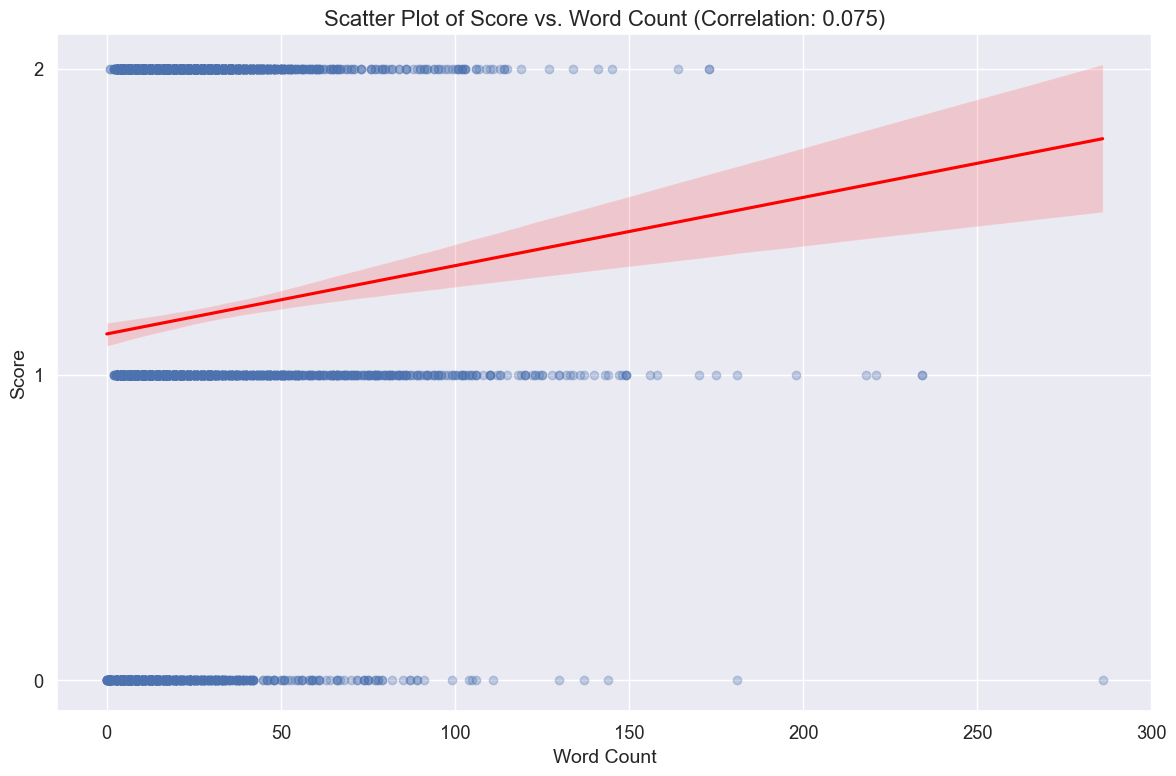

In [18]:
# Calculate correlation between word count and score
correlation = train_df[[score_column, 'word_count']].corr().iloc[0, 1]

print(f"Correlation between response length (word count) and score: {correlation:.3f}")

# Scatter plot with regression line
plt.figure(figsize=(12, 8))
sns.regplot(x='word_count', y=score_column, data=train_df, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title(f'Scatter Plot of Score vs. Word Count (Correlation: {correlation:.3f})', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.yticks([0, 1, 2])

plt.tight_layout()
plt.show()

## 5. Partial Credit Analysis (train.csv)

In [19]:
# Focus on responses with score 1 (partial credit)
partial_credit_df = train_df[train_df[score_column] == 1]

# Print basic statistics
print(f"Total responses with partial credit (score 1): {len(partial_credit_df)}")
print(f"Percentage of responses with partial credit: {len(partial_credit_df) / len(train_df) * 100:.1f}%")

Total responses with partial credit (score 1): 1268
Percentage of responses with partial credit: 34.6%


In [21]:
# Analyze partial credit distribution by question
partial_credit_by_question = train_df.pivot_table(
    index=question_col,
    columns=score_column,
    values=answer_col,
    aggfunc='count',
    fill_value=0
)

# Calculate percentage of partial credit for each question
partial_credit_by_question['total'] = partial_credit_by_question.sum(axis=1)
partial_credit_by_question['pct_partial'] = partial_credit_by_question[1] / partial_credit_by_question['total'] * 100

# Sort by percentage of partial credit (descending)
partial_credit_by_question = partial_credit_by_question.sort_values('pct_partial', ascending=False)

# Filter questions with at least 10 responses
filtered_pc = partial_credit_by_question[partial_credit_by_question['total'] >= 10]

In [22]:
# Display top 10 questions with highest percentage of partial credit
top10_partial = filtered_pc.head(10)
print("Top 10 Questions with Highest Percentage of Partial Credit:")
display(top10_partial[['total', 'pct_partial']].rename(
    columns={'total': 'Total Responses', 'pct_partial': '% Partial Credit'})
)

Top 10 Questions with Highest Percentage of Partial Credit:


output_label,Total Responses,% Partial Credit
Question_id,,
38602.0,27,74.074074
324707.0,11,72.727273
248101.0,22,63.636364
301392.0,140,62.142857
219127.0,314,60.191083
344832.0,35,60.000000
42546.0,120,60.000000
324712.0,15,60.000000
76517.0,34,58.823529


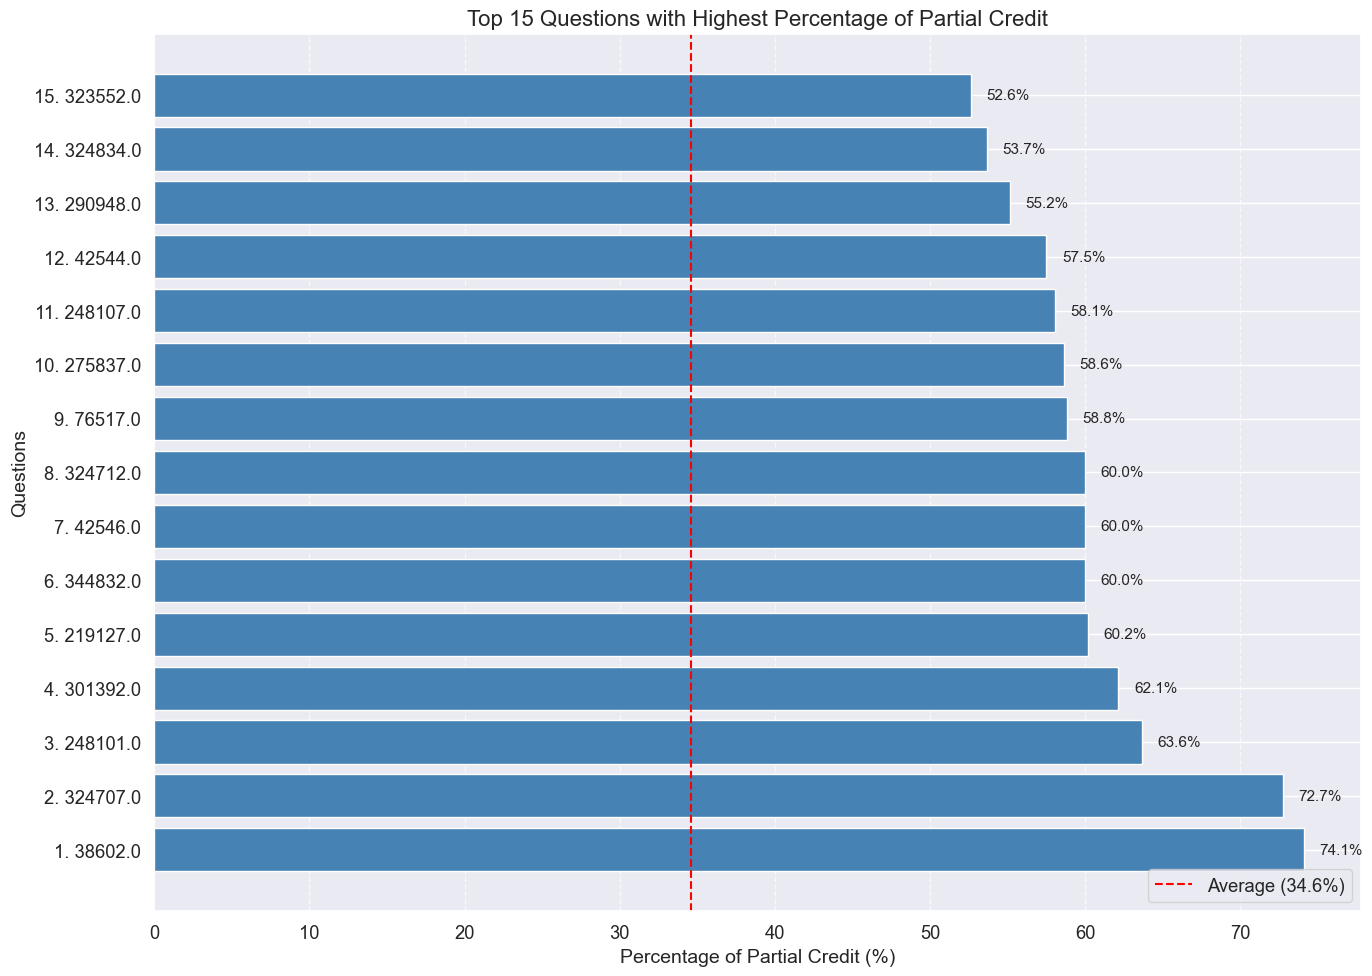


Question reference table:
1. 38602.0 - 74.1% partial credit
2. 324707.0 - 72.7% partial credit
3. 248101.0 - 63.6% partial credit
4. 301392.0 - 62.1% partial credit
5. 219127.0 - 60.2% partial credit
6. 344832.0 - 60.0% partial credit
7. 42546.0 - 60.0% partial credit
8. 324712.0 - 60.0% partial credit
9. 76517.0 - 58.8% partial credit
10. 275837.0 - 58.6% partial credit
11. 248107.0 - 58.1% partial credit
12. 42544.0 - 57.5% partial credit
13. 290948.0 - 55.2% partial credit
14. 324834.0 - 53.7% partial credit
15. 323552.0 - 52.6% partial credit


In [24]:
# Visualize top 15 questions with highest partial credit percentage
top15_partial = filtered_pc.head(15)

# Create shorter question labels for better display
def truncate_text(text, max_len=50):
    if isinstance(text, str) and len(text) > max_len:
        return text[:max_len] + '...'
    return text

# Create truncated labels and number them for clarity
question_labels = [f"{i+1}. {truncate_text(q)}" for i, q in enumerate(top15_partial.index)]

plt.figure(figsize=(14, 10))
# Use a horizontal bar chart (barh) instead of vertical
bars = plt.barh(y=range(len(question_labels)), width=top15_partial['pct_partial'], color='steelblue')
plt.yticks(range(len(question_labels)), question_labels)
plt.title('Top 15 Questions with Highest Percentage of Partial Credit', fontsize=16)
plt.xlabel('Percentage of Partial Credit (%)', fontsize=14)
plt.ylabel('Questions', fontsize=14)

# Add the percentage values at the end of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f"{top15_partial['pct_partial'].iloc[i]:.1f}%",
             va='center', fontsize=11)

# Add a vertical line for average
avg_partial = filtered_pc['pct_partial'].mean()
plt.axvline(x=avg_partial, color='red', linestyle='--', 
            label=f"Average ({avg_partial:.1f}%)")

plt.legend(loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optionally, create a table showing question numbers, text and percentages
print("\nQuestion reference table:")
for i, (question, row) in enumerate(top15_partial.iterrows()):
    print(f"{i+1}. {truncate_text(question)} - {row['pct_partial']:.1f}% partial credit")